## Human activities classification 

#### Import libraries 

In [8]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from scipy import stats
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import keras
from keras import regularizers
from keras.layers import Input, Dense, GlobalAveragePooling1D, MaxPooling1D
from keras.callbacks import ModelCheckpoint
from keras.layers import Conv1D, BatchNormalization, Activation, concatenate
from keras.layers import LSTM, Flatten
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import to_categorical
import keras.backend as K
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.layers import TimeDistributed
from keras.layers import Bidirectional, Embedding
from keras.models import Sequential

#### Hyper-parameters 

In [2]:
RANDOM_SEED = 13

# Data preprocessing
TIME_STEP = 100

# Model
N_CLASSES = 6
N_FEATURES = 3  # x-acceleration, y-acceleration, z-acceleration

# Hyperparameters
N_LSTM_LAYERS = 2
N_EPOCHS = 15
L2_LOSS = 0.0015
LEARNING_RATE = 0.0025

# Hyperparameters optimized
SEGMENT_TIME_SIZE = 180
N_HIDDEN_NEURONS = 30
BATCH_SIZE = 32

#### Load data 
Each datum is a 3-dimensional time series (x,y and z directions of accelerometer)

In [3]:
##################################################
### GLOBAL VARIABLES
##################################################
COLUMN_NAMES = [
    'user',
    'activity',
    'timestamp',
    'x-axis',
    'y-axis',
    'z-axis'
]

LABELS = [
    'Downstairs',
    'Jogging',
    'Sitting',
    'Standing',
    'Upstairs',
    'Walking'
]

DATA_PATH = 'data/WISDM_ar_v1.1_raw.txt'
data = pd.read_csv(DATA_PATH, header=None, names=COLUMN_NAMES)
data['z-axis'].replace({';': ''}, regex=True, inplace=True)
data = data.dropna()

#### Define model 
Model 1 is inspired by Paper: "Convolutional Neural Networks for human activity recognition using mobile sensors", Ming Zeng, et al, 2014
https://ieeexplore.ieee.org/document/7026300

In [13]:
def model1():
    n_feature_maps = 64
    ip = keras.layers.Input(shape=(SEGMENT_TIME_SIZE, N_FEATURES), name='main_input')
    
    # BLOCK 1 
    conv_x = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=8, padding='same')(ip)
    conv_x = keras.layers.normalization.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)

    conv_y = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=5, padding='same')(conv_x)
    conv_y = keras.layers.normalization.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)

    conv_z = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=3, padding='same')(conv_y)
    conv_z = keras.layers.normalization.BatchNormalization()(conv_z)

    # expand channels for the sum 
    shortcut_y = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=1, padding='same')(ip)
    shortcut_y = keras.layers.normalization.BatchNormalization()(shortcut_y)

    output_block_1 = keras.layers.add([shortcut_y, conv_z])
    output_block_1 = keras.layers.Activation('relu')(output_block_1)

	# BLOCK 2 
    conv_x = keras.layers.Conv1D(filters=n_feature_maps*2, kernel_size=8, padding='same')(output_block_1)
    conv_x = keras.layers.normalization.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)

    conv_y = keras.layers.Conv1D(filters=n_feature_maps*2, kernel_size=5, padding='same')(conv_x)
    conv_y = keras.layers.normalization.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)

    conv_z = keras.layers.Conv1D(filters=n_feature_maps*2, kernel_size=3, padding='same')(conv_y)
    conv_z = keras.layers.normalization.BatchNormalization()(conv_z)

	# expand channels for the sum 
    shortcut_y = keras.layers.Conv1D(filters=n_feature_maps*2, kernel_size=1, padding='same')(output_block_1)
    shortcut_y = keras.layers.normalization.BatchNormalization()(shortcut_y)

    output_block_2 = keras.layers.add([shortcut_y, conv_z])
    output_block_2 = keras.layers.Activation('relu')(output_block_2)

	# BLOCK 3 
    conv_x = keras.layers.Conv1D(filters=n_feature_maps*2, kernel_size=8, padding='same')(output_block_2)
    conv_x = keras.layers.normalization.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)

    conv_y = keras.layers.Conv1D(filters=n_feature_maps*2, kernel_size=5, padding='same')(conv_x)
    conv_y = keras.layers.normalization.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)

    conv_z = keras.layers.Conv1D(filters=n_feature_maps*2, kernel_size=3, padding='same')(conv_y)
    conv_z = keras.layers.normalization.BatchNormalization()(conv_z)

	# no need to expand channels because they are equal 
    shortcut_y = keras.layers.normalization.BatchNormalization()(output_block_2)

    output_block_3 = keras.layers.add([shortcut_y, conv_z])
    output_block_3 = keras.layers.Activation('relu')(output_block_3)

	# FINAL 
		
    gap_layer = keras.layers.GlobalAveragePooling1D()(output_block_3)
    out = keras.layers.Dense(N_CLASSES, activation='softmax')(gap_layer)
    
    model = Model(ip, out)
    model.summary()
    
    return model

#### Training 

In [14]:
# DATA PREPROCESSING
data_convoluted = []
labels = []

# Slide a "SEGMENT_TIME_SIZE" wide window with a step size of "TIME_STEP"
for i in range(0, len(data) - SEGMENT_TIME_SIZE, TIME_STEP):
    x = data['x-axis'].values[i: i + SEGMENT_TIME_SIZE]
    y = data['y-axis'].values[i: i + SEGMENT_TIME_SIZE]
    z = data['z-axis'].values[i: i + SEGMENT_TIME_SIZE]
    data_convoluted.append([x, y, z])

    # Label for a data window is the label that appears most commonly
    label = stats.mode(data['activity'][i: i + SEGMENT_TIME_SIZE])[0][0]
    labels.append(label)

# Convert to numpy
data_convoluted = np.asarray(data_convoluted, dtype=np.float32).transpose(0, 2, 1)

# One-hot encoding
labels = np.asarray(pd.get_dummies(labels), dtype=np.float32)
print("Convoluted data shape: ", data_convoluted.shape)
print("Labels shape:", labels.shape)

# SPLIT INTO TRAINING AND TEST SETS
X_train1, X_test, y_train1, y_test = train_test_split(data_convoluted, labels, test_size=0.2, random_state=RANDOM_SEED)
X_train, X_val, y_train, y_val = train_test_split(X_train1, y_train1, test_size=0.25, random_state=RANDOM_SEED)
print("X train size: ", len(X_train))
print("X test size: ", len(X_test))
print("X val size: ", len(X_val))
print("y train size: ", len(y_train))
print("y test size: ", len(y_test))
print("y val size: ", len(y_val))
    
######### Training #########
weight_fn = "./weights_simon.h5"
model_checkpoint = ModelCheckpoint(weight_fn, verbose=1, mode='max', monitor='val_acc', save_best_only=True, save_weights_only=True)
stop = EarlyStopping(monitor='val_loss', patience=15)
callback_list = [model_checkpoint, stop]
optm = Adam(lr=LEARNING_RATE)

model = model1()

model.compile(optimizer=optm, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=N_EPOCHS, callbacks = callback_list, verbose=2, validation_data=(X_val, y_val))

Convoluted data shape:  (10981, 180, 3)
Labels shape: (10981, 6)
X train size:  6588
X test size:  2197
X val size:  2196
y train size:  6588
y test size:  2197
y val size:  2196
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 180, 3)       0                                            
__________________________________________________________________________________________________
conv1d_24 (Conv1D)              (None, 180, 64)      1600        main_input[0][0]                 
__________________________________________________________________________________________________
batch_normalization_25 (BatchNo (None, 180, 64)      256         conv1d_24[0][0]                  
__________________________________________________________________________________________________
activation_19 (Activation)   

Train on 6588 samples, validate on 2196 samples
Epoch 1/15
 - 72s - loss: 0.3791 - acc: 0.8672 - val_loss: 0.5976 - val_acc: 0.8074

Epoch 00001: val_acc improved from -inf to 0.80738, saving model to ./weights_simon.h5
Epoch 2/15
 - 70s - loss: 0.1613 - acc: 0.9437 - val_loss: 0.5401 - val_acc: 0.8342

Epoch 00002: val_acc improved from 0.80738 to 0.83424, saving model to ./weights_simon.h5
Epoch 3/15
 - 72s - loss: 0.1173 - acc: 0.9604 - val_loss: 0.2223 - val_acc: 0.9299

Epoch 00003: val_acc improved from 0.83424 to 0.92987, saving model to ./weights_simon.h5
Epoch 4/15
 - 71s - loss: 0.1061 - acc: 0.9652 - val_loss: 0.0968 - val_acc: 0.9681

Epoch 00004: val_acc improved from 0.92987 to 0.96812, saving model to ./weights_simon.h5
Epoch 5/15
 - 71s - loss: 0.0765 - acc: 0.9751 - val_loss: 0.0647 - val_acc: 0.9759

Epoch 00005: val_acc improved from 0.96812 to 0.97587, saving model to ./weights_simon.h5
Epoch 6/15
 - 71s - loss: 0.0810 - acc: 0.9713 - val_loss: 0.0798 - val_acc: 0.9

#### Prediction 

In [15]:
model.load_weights(weight_fn)
prediction = model.predict(X_test);
p_pred = np.argmax(prediction, axis=1)
p_test = np.argmax(y_test, axis=1)
    
cr = classification_report(p_test, p_pred)
cm = confusion_matrix(p_test, p_pred)
    
print("-------------------- Result -----------------------")
acc = np.sum(p_pred == p_test)/p_pred.shape[0]
print('Accuracy: ' + str(acc))
print(cr)
print(cm)

-------------------- Result -----------------------
Accuracy: 0.9881656804733728
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       212
           1       1.00      1.00      1.00       676
           2       0.97      0.99      0.98       140
           3       0.99      0.94      0.96        78
           4       0.95      0.99      0.97       258
           5       1.00      1.00      1.00       833

   micro avg       0.99      0.99      0.99      2197
   macro avg       0.98      0.98      0.98      2197
weighted avg       0.99      0.99      0.99      2197

[[200   0   0   0  12   0]
 [  1 674   0   0   1   0]
 [  0   0 139   1   0   0]
 [  0   1   4  73   0   0]
 [  2   0   0   0 255   1]
 [  2   1   0   0   0 830]]


#### Loss and accuracy 

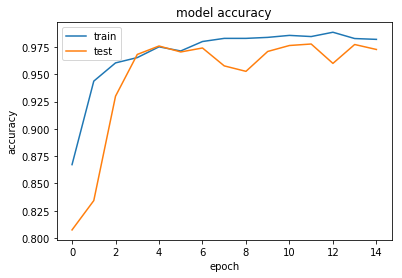

In [16]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

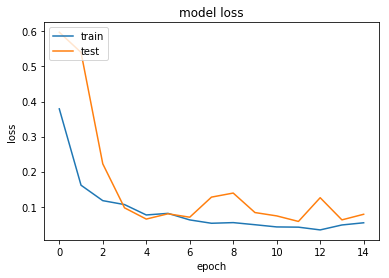

In [17]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

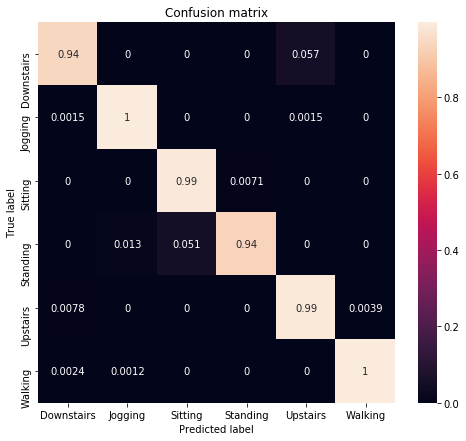

In [18]:
# CONFUSION MATRIX
plt.figure(figsize=(8, 7))
sns.heatmap(cm/(np.sum(cm, axis=1, keepdims=1)), xticklabels=LABELS, yticklabels=LABELS, annot=True);
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()